In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
path_model = "/home/xnmaster/Project/glove_transformer_depth_3_head_n_4_drop_0_2_acorrected_and_translated_fixed.pkl"

In [3]:
from models.models import *
from utils.utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = dict(
        epochs=35,
        classes=28,
        batch_size=120,
        batch_size_val_test=120,
        learning_rate=0.00005,
        patience=10,
        heads=4,
        depth=8,
        fc_transformer=315,
        dataset="ConText",
        architecture="Transformer",
        cnn = "convnext_tiny",
        weights = "DEFAULT")

model, train_loader, test_loader, val_loader = make(config)

Creating anotations...


59it [00:00, 580.56it/s]

Processed 0 images out of 24255


3105it [00:05, 563.69it/s]

Processed 3000 images out of 24255


6089it [00:10, 565.48it/s]

Processed 6000 images out of 24255


9076it [00:16, 566.66it/s]

Processed 9000 images out of 24255


12090it [00:21, 516.15it/s]

Processed 12000 images out of 24255


15066it [00:27, 531.99it/s]

Processed 15000 images out of 24255


18070it [00:32, 563.95it/s]

Processed 18000 images out of 24255


21073it [00:37, 543.09it/s]

Processed 21000 images out of 24255


24099it [00:43, 563.52it/s]

Processed 24000 images out of 24255


24255it [00:43, 557.27it/s]


In [4]:
model_dict = pickle.load(open(path_model, "rb"))
config = model_dict["parameters"]
model = Transformer(num_classes=config["classes"], depth_transformer=config["depth"], heads_transformer=config["heads"], dim_fc_transformer=config["fc_transformer"]).to(device)
model.load_state_dict(model_dict["model_weights"])

model.eval()

Transformer(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm(

In [5]:
def de_normalize(images):
  t = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                           std=[1/0.229, 1/0.224, 1/0.255])
  
  return t(images)

In [6]:
label2class = {1: "Bakery",
10:"Dry Cleaner",
11:"Funeral",
12:"Hotspot",
13:"MassageCenter",
14:"MedicalCenter",
15:"PackingStore",
16:"Pawnshop",
17:"PetShop",
18:"Pharmacy",
19:"Pizzeria",
2:"Barber",
20:"RepairShop",
21:"Restaurant",
22:"School",
23:"SteakHouse",
24:"Tavern",
25:"TeaHouse",
26:"Theatre",
27:"Tobacco",
28:"Motel",
3:"Bistro",
4:"Bookstore",
5:"Cafe",
6:"ComputerStore",
7:"CountryStore",
8:"Diner",
9:"DiscounHouse"}

In [7]:
labels, imgs, texts, text_masks = next(iter(val_loader))
labels, imgs, texts, text_masks = labels.to(device), imgs.to(device), texts.to(device), text_masks.to(device)

### Activation maps

In [8]:
def showImage(img, ax):
    out = img.numpy()
    
    # Bring to the 0-255 range
    out = out - out.min()
    out = out / out.max()
    out = out * 255
    out = out.astype('uint8')
    
    # Plot image
    ax.axes.get_xaxis().set_visible(False)        
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(out, cmap='gray')

from math import ceil
def showConvMap(conv_map, title_plot):
    # Create a grid of images
    h = conv_map.shape[0] # = number of images in the batch
    w = conv_map.shape[1] # = number of activation maps per image
    fig, ax = plt.subplots(ceil(w/10), 10, figsize=(10, 10))
    ax = ax.flatten()

    # Plot activation maps
    n = 0
    for i in range(h):
        for j in range(w):
            showImage(conv_map[i][j], ax[n])
            n += 1

    # set all axis off
    for a in ax:
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)

    # set the title of the plot
    plt.suptitle(title_plot, fontsize=15)
    
    fig.tight_layout()

In [9]:
def hook_ShowOutput(module, input, output):
    print("Output shape:", output.shape)
    showConvMap(output.cpu(), "Activation maps of the module: " + str(module.__class__.__name__))

Output shape: torch.Size([1, 96, 56, 56])


/anaconda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


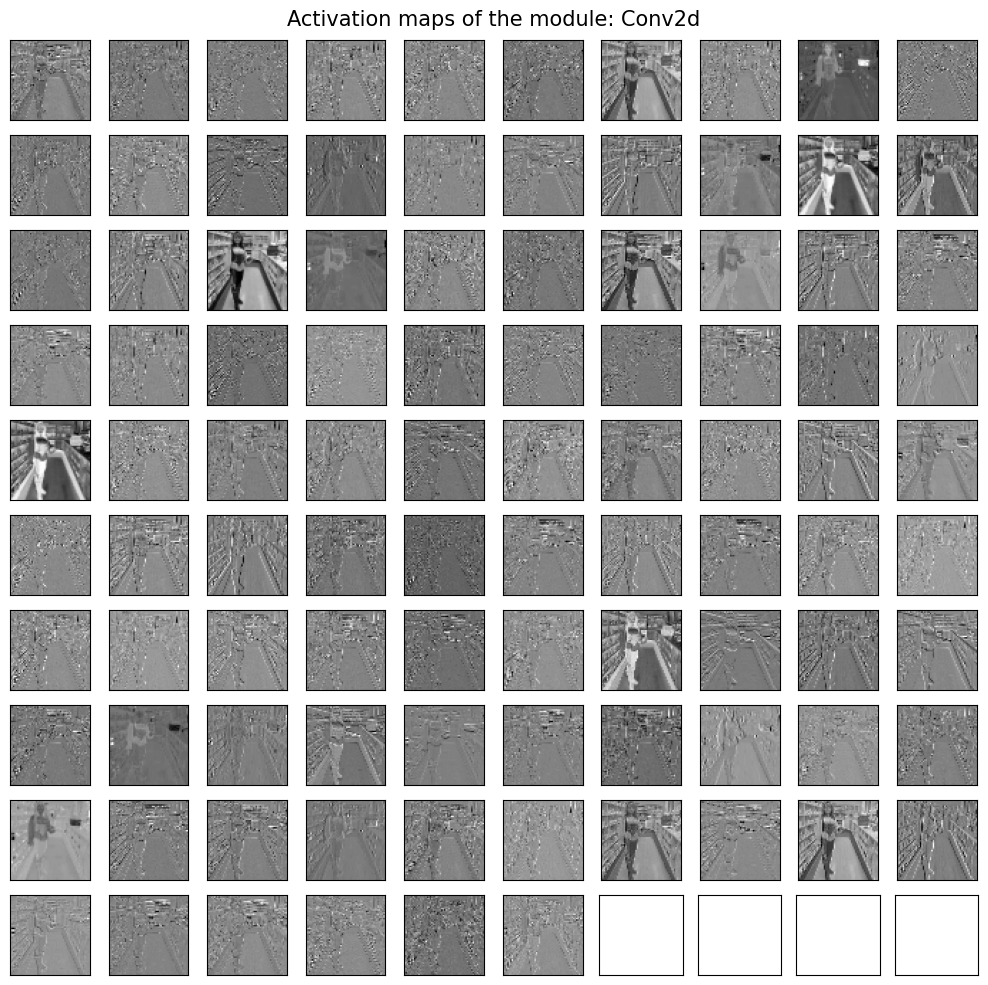

In [10]:
img = imgs[:1].to(device)
txt = texts[:1].to(device)
txt_mask = text_masks[:1].to(device)
label = labels[:1]

with torch.no_grad():
    handle = model.feature_extractor[0][0][0].register_forward_hook(hook_ShowOutput)
    output = model(img, txt, txt_mask)
    handle.remove()

Output shape: torch.Size([1, 96, 56, 56])


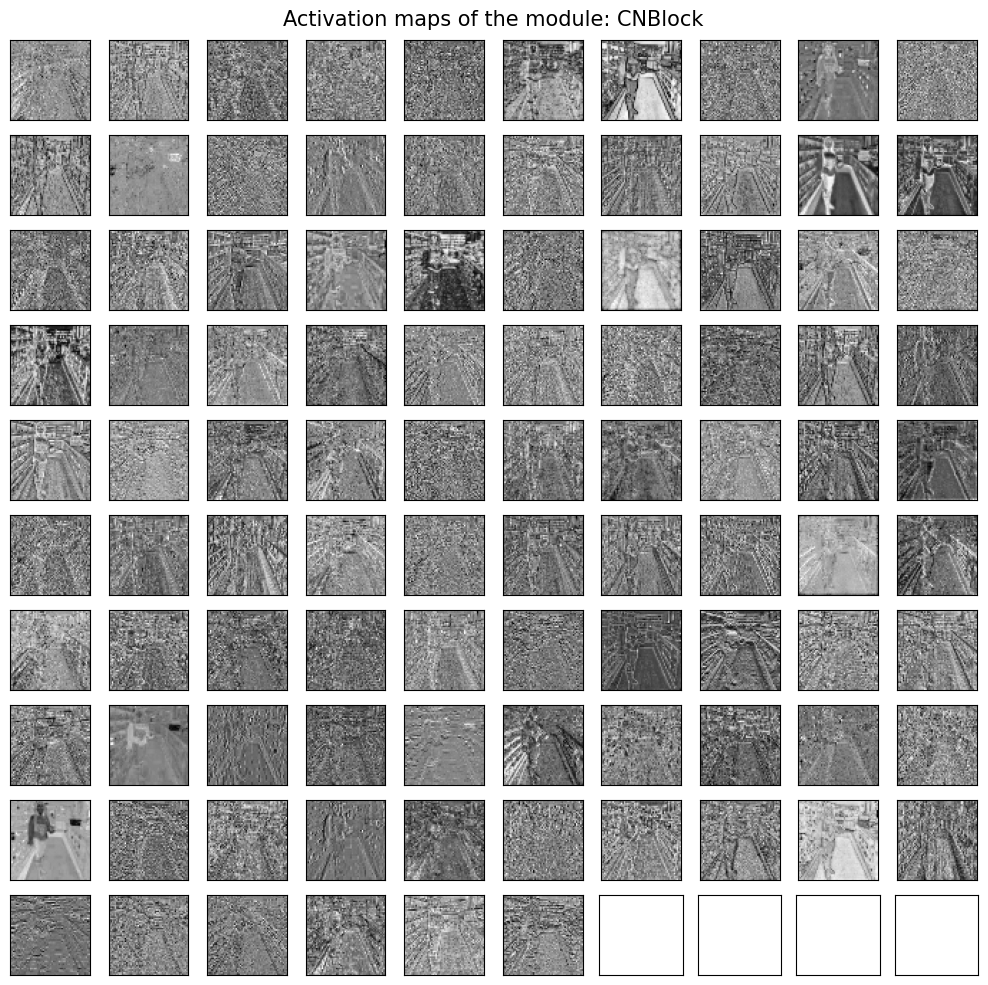

In [11]:
img = imgs[:1].to(device)
txt = texts[:1].to(device)
txt_mask = text_masks[:1].to(device)
label = labels[:1]

with torch.no_grad():
    handle = model.feature_extractor[0][1][1].register_forward_hook(hook_ShowOutput)
    output = model(img, txt, txt_mask)
    handle.remove()

### Cam grad

In [12]:
import cv2
def get_grad_cam(img, txt, txt_mask, label, loss):
    model.zero_grad()
    output = model(img, txt, txt_mask)
    loss = loss(output, label.unsqueeze(0))
    loss.backward()

    img = img = img.reshape(3, 224, 224)
    img = de_normalize(img)
    img = img.permute(1, 2, 0).cpu().numpy() 
    img -= img.min()
    img = (img / img.max()) * 255

    gradients = model.feature_extractor[0][0][0].weight.grad.cpu().numpy()
    activations = model.feature_extractor[0][0][0].weight.cpu().detach().numpy()

    importance_weights = np.mean(gradients * activations, axis=(1, 2))

    cam = np.sum(np.abs(importance_weights[:, np.newaxis, np.newaxis]) * activations, axis=0)
    cam = cam.transpose((1, 2, 0))

    cam_normalized = cv2.resize(cam, (224, 224))
    cam_normalized = np.maximum(cam_normalized, 0)
    cam_normalized = cam_normalized / cam_normalized.max()
    cam_normalized = cam_normalized * img
    cam_normalized = cam_normalized.astype('uint8')
    return cam_normalized

In [13]:
def showGradCam(img, txt, txt_mask, label, loss, cmap = "heatmap"):
    fig, ax  = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [1, 1.25]})
    grad_cam = get_grad_cam(img, txt, txt_mask, label, loss)

    img = img.reshape(3, 224, 224)
    img = de_normalize(img)
    img = img.permute(1, 2, 0).cpu().numpy() 
    img -= img.min()
    img = (img / img.max()) * 255

    if cmap == "coldmap":
        cam = cv2.applyColorMap(grad_cam, cv2.COLORMAP_JET)
        cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    
    elif cmap == "heatmap":
        cam = cv2.applyColorMap(grad_cam, cv2.COLORMAP_HOT)
        cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

    elif cmap == "colors":
        cam = cv2.cvtColor(grad_cam, cv2.COLOR_BGR2RGB)
    
    else:
        cam = grad_cam
    
    ax[0].imshow(img.astype('uint8'))
    ax[1].imshow(cam)
    ax[0].set_title("Image")
    ax[1].set_title("GradCam")
    ax[1].figure.colorbar(ax[1].imshow(cam), ax=ax[1], orientation='vertical', shrink=0.405)
    plt.tight_layout()
    plt.show()

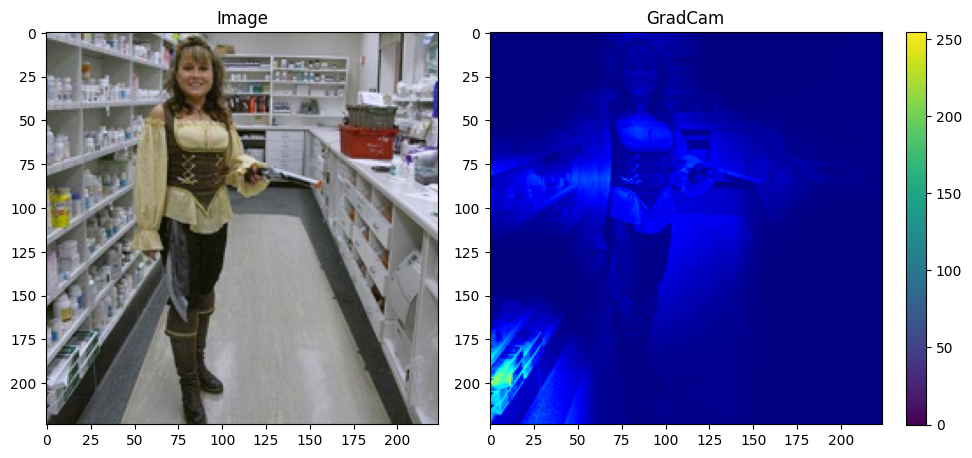

In [14]:
img = imgs[0].unsqueeze(0).to(device)
txt = texts[0].unsqueeze(0).to(device)
txt_mask = text_masks[0].unsqueeze(0).to(device)
label = labels[0]
loss = torch.nn.CrossEntropyLoss()

showGradCam(img, txt, txt_mask, label, loss, cmap="coldmap")